# Progressive Inference for Music Demixing ID: L12
Description: Using denoising diffusion approaches to train music demixing (MDX) models is
promising but requires retraining large and carefully tuned neural networks (Plaja-Roglans,
2022). Instead, we will explore a related yet different approach: can we improve separation
quality solely by scheduling the inference process using a diffusion-inspired strategy even
without retraining? By experimenting with existing MDX models (Spleeter by Deezer,Meta’s Demucs, ByteDance’s BS-Roformer, etc.), this project offers an exciting opportunity
to explore and possibly enhance the performance of state-of-the-art AI techniques.

**Resources**


(Plaja-Roglans, 2022) https://ismir2022program.ismir.net/poster_262.html
Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
MDX Challenge 2021: https://arxiv.org/abs/2108.13559
MDX Challenge 2023: https://arxiv.org/abs/2308.06979
Overview of state-of-the-art MDX models:
https://paperswithcode.com/sota/music-source-separation-on-musdb18-hq

## Preliminary step: Install and Import Libraries.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython
import torch
import torchaudio
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
import norbert

## Loading of the Model and Device Selection

In [3]:
bundle = torchaudio.pipelines.HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
sample_rate = bundle.sample_rate

cpu_device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS
model.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

Device Check:

In [4]:
device

device(type='mps')

## Loading of the Dataset and Dataset Preparation

Download the dataset at: https://zenodo.org/records/3338373

Global variables:

In [5]:
SEGMENT_LENGTH = 30  # 30 seconds of audio from each song
DATASET_FOLDER =  "./musdb18hq/test" # dataset should be inside the project folder
DATASET_FOLDER_TRIMMED = "./musdb18hq_trimmed" # trimmed dataset will be saved here

Dictionary creation

(Dataset Structure: `{track_folder -> {stem_name -> waveform}`)


In [6]:
def get_max_non_silence_start(song):
    """
    Given a song (dictionary of stem names -> waveform),
    use librosa.effects.trim to find the starting index of non-silent 
    segments for each stem and return the highest start index.
    """
    max_start = 0
    for stem, waveform in song.items():
        # Convert tensor waveform to numpy if necessary
        if hasattr(waveform, "detach"):
            waveform_np = waveform.detach().cpu().numpy()
        else:
            waveform_np = waveform
        
        # If waveform is multi-channel (shape: channels x samples)
        if waveform_np.ndim > 1:
            # Convert to mono using librosa.to_mono
            waveform_np = librosa.to_mono(waveform_np)
        else:
            waveform_np = waveform_np.squeeze()

        # Trim leading and trailing silence
        # trim returns a tuple (trimmed_audio, (start, end))
        trimmed, indices = librosa.effects.trim(waveform_np)
        if indices.size and indices[0] > max_start:
            max_start = indices[0]
            
    return max_start
def is_stem_silent(waveform, threshold=1e-4):
    """
    Determines if a given song stem is not silent.
    
    Args:
        waveform (torch.Tensor or np.ndarray): The audio waveform of the stem.
        threshold (float): The amplitude threshold below which the stem is considered silent.
    
    Returns:
        bool: True if the stem is not silent, False otherwise.
    """
    # Convert tensor waveform to numpy if necessary
    if hasattr(waveform, "detach"):
        waveform = waveform.detach().cpu().numpy()
    
    # If waveform is multi-channel (shape: channels x samples), convert to mono
    if waveform.ndim > 1:
        waveform = librosa.to_mono(waveform)
    
    # Check if the maximum absolute amplitude exceeds the threshold
    return np.max(np.abs(waveform)) < threshold
def load_and_process_dataset():
    """
    Load the dataset from the specified folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """

    # sorted list of folders in the dataset
    track_folders = sorted(
        folder for folder in os.listdir(DATASET_FOLDER)
        if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
    )

    # Dictionary to store {track_folder -> {stem_name -> waveform}}
    dataset_dict = {}

    # Each subfolder in musdb18hq/test corresponds to a song
    for track_folder in tqdm(track_folders):
        track_path = os.path.join(DATASET_FOLDER, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        stem_names = ["mixture", "drums", "bass", "vocals", "other"]
        
        for stem_name in stem_names:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            # print(f"Loading {track_folder}" + f" - {stem_name}")
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
        
        max_start = get_max_non_silence_start(stems_dict)

        # If the stem is silent, remove it from the dictionary else trim it
        for stem_name, waveform in stems_dict.items():
            if is_stem_silent(waveform) or waveform.shape[1] < SEGMENT_LENGTH * sample_rate + max_start:
                print(f"Removing silent stem: {stem_name}")
                del stems_dict[stem_name]
            else:
                # Trim the waveform to the max_start to segment samples
                duration = SEGMENT_LENGTH * sample_rate + max_start
                stems_dict[stem_name] = waveform[:, max_start:duration]

        dataset_dict[track_folder] = stems_dict

    return dataset_dict


def load_dataset():
    """
    Load the dataset from the DATASET_FOLDER_TRIMMED folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    dataset_dict = {}

    for track_folder in tqdm(os.listdir(DATASET_FOLDER_TRIMMED)):
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        
        for stem_name in ["mixture", "drums", "bass", "vocals", "other", "new_mixture"]:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
            
        dataset_dict[track_folder] = stems_dict
        
    return dataset_dict

def create_dataset(dataset_dict):
    """
    Create a dataset of trimmed audio files from the musdb18hq dataset.
    The dataset is saved in the DATASET_FOLDER_TRIMMED folder.
    It processes each track folder, saves the stems as individual files,
    and generates a new_mixture file as the sum of the stems.
    Args:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    Returns:
        None
    """
    for track_folder, stems_dict in tqdm(dataset_dict.items()):
    
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        os.makedirs(track_path, exist_ok=True)
        
        # Add new_mixture file to the track folder as the sum of the stems
        new_mixture = torch.zeros((2, SEGMENT_LENGTH * sample_rate))
        for stem_name, waveform in stems_dict.items():
            
            file_path = os.path.join(track_path, f"{stem_name}.wav")
            torchaudio.save(file_path, waveform, sample_rate=sample_rate)

            # Generation of the new_mixture file
            if stem_name != "mixture":
                new_mixture += waveform*0.25

        # Normalize the new_mixture to 1
        new_mixture = new_mixture / torch.max(torch.abs(new_mixture))
        
        # Trim the new_mixture to the desired length
        new_mixture = new_mixture[:, :SEGMENT_LENGTH * sample_rate]
        new_mixture_path = os.path.join(track_path, "new_mixture.wav")
        torchaudio.save(new_mixture_path, new_mixture, sample_rate)
        #print(f"Saved new mixture to {new_mixture_path}")
        
        # Add the new_mixture to stems_dict and update dataset_dict
        stems_dict["new_mixture"] = new_mixture
        dataset_dict[track_folder] = stems_dict  # Update the dataset_dict explicitly
        #print(f"Added new_mixture to stems_dict for track {track_folder}")


def load_or_create_trimmed_dataset():
    """
    Load or create the trimmed dataset.
    If the dataset already exists, it loads the dataset from the musdb18hq_trimmed folder.
    If the dataset does not exist, it processes the musdb18hq/test folder and saves the trimmed dataset.
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    # Check if the trimmed dataset already exists
    if os.path.isdir(DATASET_FOLDER_TRIMMED):
        print("Dataset already exists.")

        # Load the trimmed dataset
        dataset_dict = load_dataset()
        print("Dataset loaded.")
    else:
        print("Loading dataset...")
        dataset_dict = load_and_process_dataset()
        print("Dataset loaded.")
    
        # Save the trimmed dataset
        os.makedirs(DATASET_FOLDER_TRIMMED, exist_ok=True)
        create_dataset(dataset_dict)

        print("Trimmed dataset saved.")
    
    return dataset_dict

Save the new DATASET FOLDER

In [7]:
dataset_dict = load_or_create_trimmed_dataset()

Loading dataset...


100%|██████████| 50/50 [01:56<00:00,  2.34s/it]


Dataset loaded.


100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Trimmed dataset saved.


Trimmed tracks check

In [8]:
print("Number of keys in dataset_dict:", len(dataset_dict))

# Check the first track folder and its contents
first_track_folder = list(dataset_dict.keys())[0]
print("First track folder:", first_track_folder)
print("Contents of the first track folder:")
def print_stem_shapes(first_track_folder):
    for stem_name in dataset_dict[first_track_folder].keys():
        print(f" - {stem_name}: {dataset_dict[first_track_folder][stem_name].shape}")

print_stem_shapes(first_track_folder)


Number of keys in dataset_dict: 50
First track folder: AM Contra - Heart Peripheral
Contents of the first track folder:
 - mixture: torch.Size([2, 1323000])
 - drums: torch.Size([2, 1323000])
 - bass: torch.Size([2, 1323000])
 - vocals: torch.Size([2, 1323000])
 - other: torch.Size([2, 1323000])
 - new_mixture: torch.Size([2, 1323000])


In [9]:
# reduce to 10 tracks the dataset_dict
dataset_dict_reduced = {k: dataset_dict[k] for k in list(dataset_dict)[:10]}

Function to separate the sources


In [10]:
def separate_sources(
    model,
    mix,
    sample_rate=sample_rate,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None,
    normalize=True,
):
    """
    Separate sources from a mixture using the provided model.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        sample_rate: Sample rate of the audio.
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
    Returns:
        final: The separated sources tensor (batch, sources[drums, bass, other, vocel], channels, length). #CORRECT ORDER UPDATED
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # normalize the input by its RMS
    if normalize:
        # mix = mix / torch.sqrt(torch.mean(mix ** 2, dim=-1, keepdim=True))
        mix = mix / torch.max(torch.abs(mix))

    # chunk_len for entire 30s, no overlap
    chunk_len = int(mix.shape[2] * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = torchaudio.transforms.Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk).to(device)
            
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

Evaluation of the results

In [11]:
def evaluate_sdr(original_stem: torch.Tensor, predicted_stem: torch.Tensor, device: torch.device=None):
    """
    Calculate the Scale-Invariant Signal-to-Distortion Ratio (SDR) between the original and predicted stems.

    Args:
        original_stem (torch.Tensor): The original stem waveform (shape: [channels, samples]).
        predicted_stem (torch.Tensor): The predicted stem waveform (shape: [channels, samples]).

    Returns:
        float: The SDR value.
    """
    # Ensure both tensors are on the same device
    original_stem.to(device)
    predicted_stem.to(device)
    
    # Initialize the SDR metric
    sdr_metric = ScaleInvariantSignalDistortionRatio().to(device)

    # Compute the SDR
    sdr_value = sdr_metric(predicted_stem, original_stem).item()

    return sdr_value

Testing the effect of the volume on the SDR on the same stem

In [12]:
def assess_sdr_for_volume_change(volume_change_factor=0.25, verbose=True):
    """
    Assess the Scale-Invariant Signal-to-Distortion Ratio (SDR) for a volume change scenario.
    This function retrieves a specific track from the dataset, modifies its volume, and evaluates the SDR
    between the original stem and the modified stem.
    Args:
        volume_change_factor (float): Factor by which to change the volume of the stem (default: 0.25 (-12 dB)).
        verbose (bool): If True, prints detailed information about the SDR calculations.
    Returns:
        tuple: SDR values for the original stem against itself and the modified stem against the original.
    """
    track_names = list(dataset_dict.keys())

    sdr_results = []

    for track_chosen in tqdm(track_names, desc="Processing tracks"):
        # Retrieve the original "vocals" waveform from the specified track
        original_stem_test = dataset_dict[track_chosen]["vocals"]

        # Create a new version with a different volume
        different_vol_stem_test = original_stem_test * volume_change_factor

        # Evaluate SDR when comparing the original stem to itself
        sdr_original = evaluate_sdr(original_stem_test, original_stem_test, device=device)

        # Evaluate SDR when comparing the scaled stem to the original
        sdr_different = evaluate_sdr(original_stem_test, different_vol_stem_test, device=device)

        # Append results for this track
        sdr_results.append({
            "track": track_chosen,
            "sdr_original": sdr_original,
            "sdr_different": sdr_different
        })
    
    # Calculate the average SDR values across all tracks
    sdr_original = np.mean([result["sdr_original"] for result in sdr_results])
    sdr_different = np.mean([result["sdr_different"] for result in sdr_results])
    if verbose:
        print(f"\nAverage SDR for original volume vs. itself: {sdr_original:.2f} dB")
        print(f"Average SDR for different volume vs. original: {sdr_different:.2f} dB")
        print(f"Difference in SDR: {sdr_original - sdr_different:.2f} dB")

    return sdr_original, sdr_different

sdr_original, sdr_different = assess_sdr_for_volume_change()

Processing tracks: 100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


Average SDR for original volume vs. itself: 104.82 dB
Average SDR for different volume vs. original: 92.78 dB
Difference in SDR: 12.04 dB


Evaluation of the model in standard usage

<b> `compute_sdrs` </b>
This function computes the Scale-Invariant Signal-to-Distortion Ratio (SDR) for each stem. It compares the original stems from `stems_dict` with the predicted stems from `separated_sources` using the `evaluate_sdr` function. The SDR values are stored in a dictionary (`sdr_results`) with stem names as keys.

In [13]:
def compute_sdrs(model, stems_dict, separated_sources, device):
    """Compute SDRs for each stem."""
    sdr_results = {stem: [] for stem in model.sources}
    for i, stem_name in enumerate(model.sources):
        original_stem = stems_dict[stem_name].to(device)
        predicted_stem = separated_sources[0, i].to(device)
        sdr_value = evaluate_sdr(original_stem, predicted_stem, device=device)
        sdr_results[stem_name].append(sdr_value)
    return sdr_results

In [14]:
def evaluate_sdr_across_dataset(dataset_dict, model, sample_rate, device, normalize, verbose=False):
    """
    Evaluate the SDR for each track in the dataset.
    Args:
        dataset_dict (dict): Dictionary containing the dataset.
        model: The separation model.
        sample_rate: Sample rate of the audio.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        verbose (bool): Whether to print detailed logs.
    Returns:
        average_sdr (dict): Dictionary containing the average SDR for each stem.
    """
    sdr_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}

    sdr_results_list = []

    for track_name, stems_dict in tqdm(dataset_dict.items()):
        if verbose:
            print(f"Processing track: {track_name}")

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            if verbose:
                print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)  # Add batch dimension
        
        # Perform source separation
        separated_sources = separate_sources(model, mixture, sample_rate=sample_rate, device=device, normalize=normalize)

        # Evaluate SDR for each stem
        sdr_results = compute_sdrs(model, stems_dict, separated_sources, device)

        # Convert sdr_results to a tensor for this track
        sdr_tensor = torch.tensor([sdr_results[stem][0] for stem in model.sources])
        
        # Append the SDR tensor to the collection
        sdr_results_list.append(sdr_tensor)

    # Calculate the average and standard deviation SDR for each stem
    if sdr_results_list:
        sdr_collection = torch.stack(sdr_results_list)
        average_sdr = {stem: torch.mean(sdr_collection[:, i]).item() for i, stem in enumerate(model.sources)}
        std_sdr = {stem: torch.std(sdr_collection[:, i]).item() for i, stem in enumerate(model.sources)}
    else:
        average_sdr = {stem: None for stem in model.sources}
        std_sdr = {stem: None for stem in model.sources}

    if verbose:
        print("\nAverage SDR for each stem:")
        for stem, avg_sdr in average_sdr.items():
            print(f"{stem}: {avg_sdr:.2f} dB" if avg_sdr is not None else f"{stem}: No data")
        print("\nStandard Deviation of SDR for each stem:")
        for stem, std in std_sdr.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")

    return average_sdr, std_sdr

In [15]:
# Evaluate SDR across the dataset using the provided function using no normalization.
average_sdr, std_sdr = evaluate_sdr_across_dataset(dataset_dict, model, sample_rate, device, normalize=False)

100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


In [16]:
def plot_sdr_results(average_sdr, std_sdr):
    """
    Plot the SDR results for each stem with error bars showing standard deviation.

    Args:
        average_sdr (dict): Dictionary containing the average SDR for each stem.
        std_sdr (dict): Dictionary containing the standard deviation of SDR for each stem.
    """
    stems = list(average_sdr.keys())
    sdr_values = [average_sdr[stem] for stem in stems]
    std_values = [std_sdr[stem] for stem in stems]

    plt.figure(figsize=(10, 5))
    plt.bar(stems, sdr_values, yerr=std_values, capsize=5, color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Stem')
    plt.ylabel('Average SDR (dB)')
    plt.title('Average SDR for Each Stem with Standard Deviation')
    plt.ylim([0, max(sdr_values) + max(std_values) + 5])
    plt.grid(axis='y')
    plt.show()

Average SDR results per stem: {'drums': 12.366437911987305, 'bass': 11.146015167236328, 'other': 6.666745662689209, 'vocals': 9.95559310913086}
Standard Deviation of SDR results per stem: {'drums': 3.8710579872131348, 'bass': 4.747978210449219, 'other': 2.720107078552246, 'vocals': 3.5867106914520264}


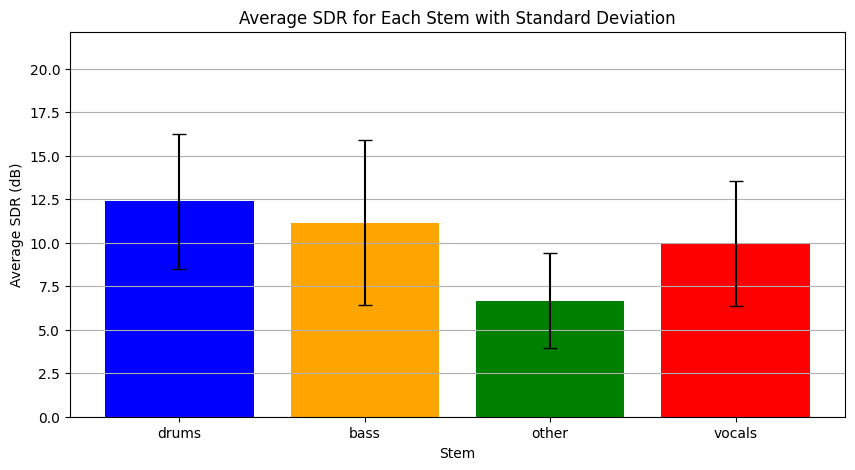

In [17]:
print("Average SDR results per stem:", average_sdr)
print("Standard Deviation of SDR results per stem:", std_sdr)

# Plot the SDR results
plot_sdr_results(average_sdr, std_sdr)

## Motivation

In [18]:
def schedule(initial_gains, step, steps, target_stem, schedule_type):
    """
    Create a schedule for the target stem's gain based on the specified schedule type.

    Args:
        initial_gains (dict): Dictionary of initial gains for each stem.
        step (int): The current step in the schedule.
        steps (int): The total number of steps in the schedule.
        target_stem (str): The stem to which the schedule is applied.
        schedule_type (str): The type of schedule ('linear', 'exponential', or 'constant').

    Returns:
        dict: Updated gains for each stem.
    """
    if schedule_type == "linear":
        # Linear 
        next_value = initial_gains[target_stem] * step
    elif schedule_type == "exponential":
        # Exponential
        next_value = initial_gains[target_stem] * np.exp(step / steps)
    elif schedule_type == "constant":
        # Constant
        next_value = initial_gains[target_stem]
    else:
        raise ValueError("Invalid schedule type. Choose from 'linear', 'exponential', or 'constant'.")

    # Update the target stem's gain
    updated_gains = initial_gains.copy()
    updated_gains[target_stem] = next_value

    # Normalize the gains
    total_gain = sum(updated_gains.values())
    for stem in updated_gains:
        updated_gains[stem] /= total_gain

    return updated_gains

In [19]:
def add_up_all_sources(model, mix, target_stem, initial_gains, steps, schedule_type, separated_sources, step):
    """
    Generate a new mixture based on the current step and schedule type.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        target_stem: The target stem to be enhanced.
        initial_gains: Initial gains for each stem.
        steps: Number of steps for progressive inference.
        schedule_type: Type of schedule ('linear', 'exponential', or 'constant').
        separated_sources: The separated sources tensor (batch, sources, channels, length).
        step: Current step in the schedule.
    Returns:
        new_mix: The new mixture tensor after applying the gains.
    """
    # update the gains based on the schedule
    gains = schedule(initial_gains, step, steps, target_stem=target_stem, schedule_type=schedule_type)
        
    # create the new mixture and apply the gains to the separated sources
    new_mix = torch.zeros_like(mix)
    for i, stem_name in enumerate(model.sources):
        new_mix += separated_sources[:, i] * gains[stem_name]
    return new_mix


In [20]:
def add_target_to_mixture(mix, separated_sources, index, step, steps):
    """
    Create a new mixture by applying a function inspired by diffusion models.
    This function progressively adds the target stem from the separated sources to the original mixture.
    The amount added is controlled by the step in the progressive inference.
    The new mixture is normalized to ensure it does not exceed the maximum amplitude.

    Args:
        mix (torch.Tensor): Original mixture tensor.
        separated_sources (torch.Tensor): Tensor of separated sources.
        index (int): Index of the target stem in the separated sources.
        step (int): Current step in the progressive inference.
        steps (int): Total number of steps.

    Returns:
        torch.Tensor: New mixture tensor.
    """
    new_mix = torch.zeros_like(mix)
    beta = step / steps
    new_mix = mix * (1 - beta) + separated_sources[:, index] * beta
    new_mix = new_mix / new_mix.max()  # Normalize the new mixture
    return new_mix


In [21]:
def generate_new_mixture_with_original_stems(mix, device, stems_dict, target_stem, step):
    """
    Generate a new mixture by adding up the original stems of the song and increasing
    the volume of the target stem linearly based on the step and steps.

    Args:
        mix (torch.Tensor): Original mixture tensor.
        device (torch.device): Device to run the computation on.
        stems_dict (dict): Dictionary containing the original stems of the song.
        target_stem (str): The stem to be enhanced in the new mixture.
        step (int): Current step in the progressive inference.

    Returns:
        torch.Tensor: The new mixture tensor.
    """
    new_mix = torch.zeros_like(mix)

    for stem_name, waveform in stems_dict.items():
        if stem_name == target_stem:
            # Increase the volume of the target stem linearly
            volume_factor = step
            new_mix += waveform.to(device) * volume_factor
        else:
            new_mix += waveform.to(device)

    # Normalize the new mixture to avoid clipping
    new_mix = new_mix / torch.max(torch.abs(new_mix))

    return new_mix

In [22]:
def wiener_filtering(separated_sources, reference_stem, stem_index):
    """
    Apply Wiener filtering to improve the separation of a target stem.

    Args:
        separated_sources (torch.Tensor): Tensor of separated sources (batch, sources, channels, length).
        reference_stem (torch.Tensor): Reference stem tensor (channels, length).
        stem_index (int): Index of the target stem in separated_sources.

    Returns:
        torch.Tensor: Tensor of the filtered target stem.
    """
    # Compute the accompaniment by subtracting the target stem from the reference stem
    accomp = (reference_stem - separated_sources[:, stem_index]).squeeze(0)

    # Extract the target stem
    separated_stem = separated_sources[:, stem_index].squeeze(0)

    # Perform STFT for each channel of the target and accompaniment
    target_spec_list = [librosa.stft(separated_stem[channel].cpu().numpy()).T for channel in range(separated_stem.shape[0])]
    accomp_spec_list = [librosa.stft(accomp[channel].cpu().numpy()).T for channel in range(accomp.shape[0])]

    # Compute magnitude and phase for the target and accompaniment
    target_mag = np.stack([np.abs(spec) for spec in target_spec_list], axis=-1)
    target_phase = np.stack([np.angle(spec) for spec in target_spec_list], axis=-1)
    accomp_mag = np.stack([np.abs(spec) for spec in accomp_spec_list], axis=-1)

    # Prepare inputs for Wiener filtering
    mix_spec = librosa.stft(reference_stem.cpu().numpy()).T
    sources = np.transpose(np.stack([target_mag, accomp_mag], axis=0), [1, 2, 3, 0])

    # Apply Wiener filtering
    specs = norbert.wiener(sources, mix_spec)

    # Reconstruct the target spectrogram with the original phase
    target_spec = np.abs(specs[:, :, :, 0]) * np.exp(1j * target_phase)

    # Perform inverse STFT for each channel
    pred_audio_list = [librosa.istft(target_spec[:, :, channel].T) for channel in range(target_spec.shape[2])]

    # Combine channels to create the stereo output
    pred_audio = np.stack(pred_audio_list, axis=-1).T

    # Convert the result to a tensor and adjust dimensions to match separated_sources
    pred_audio_tensor = torch.from_numpy(pred_audio).to(reference_stem.device).unsqueeze(0).unsqueeze(0)

    # Ensure compatibility with separated_sources dimensions
    if pred_audio_tensor.shape[2] != separated_sources.shape[2]:
        pred_audio_tensor = pred_audio_tensor.repeat(1, separated_sources.shape[2], 1)

    if pred_audio_tensor.shape[3] != separated_sources.shape[3]:
        if pred_audio_tensor.shape[3] < separated_sources.shape[3]:
            pred_audio_tensor = torch.nn.functional.pad(pred_audio_tensor, (0, separated_sources.shape[3] - pred_audio_tensor.shape[3]))
        else:
            pred_audio_tensor = pred_audio_tensor[:, :, :, :separated_sources.shape[3]]

    return pred_audio_tensor


In [23]:
def progressive_inference(
    model,
    mix,
    target_stem,
    reference_stems,
    initial_gains,
    sample_rate,
    mixture_update_mode="add sources",
    overlap=0.0, 
    device=None,
    normalize=True,
    wiener_filter=False,
    steps=10,
    schedule_type="linear",
):
    """
    Perform progressive inference on the mixture using the specified model and schedule.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        target_stem: The target stem to be enhanced.
        reference_stems: Dictionary of reference stems for evaluation.
        initial_gains: Initial gains for each stem.
        sample_rate: Sample rate of the audio.
        mixture_update_mode: Mode for updating the mixture ('add sources', 'add to mixture' or 'oracle predictor').
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        wiener_filter: Whether to apply Wiener filtering to the target stem.
        steps: Number of steps for progressive inference.
        schedule_type: Type of schedule ('linear', 'exponential', or 'constant').
    Returns:
        separated_sources: The separated sources tensor (batch, sources, channels, length).
        sdr_results: List of dictionaries containing SDR results for each step.
    """

    sdr_results = []  # List to store SDR results for each step

    target_index = model.sources.index(target_stem)

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    separated_sources = separate_sources(model, mix, sample_rate=sample_rate, overlap=overlap, device=device, normalize=normalize)

    if wiener_filter:
        print("Applying Wiener filtering...")
        separated_sources[:, target_index] = wiener_filtering(separated_sources, mix, target_index)

    # Compute SDR for the initial step
    initial_sdr_results = compute_sdrs(model, reference_stems, separated_sources, device)
    sdr_results.append(initial_sdr_results)

    # Progressive inference steps
    for step in range(1 , steps + 1): # start from 1 to steps inclusive
        # Update the mixture
        if mixture_update_mode == "add sources":
            new_mix = add_up_all_sources(model, mix, target_stem, initial_gains, steps, schedule_type, separated_sources, step)
        elif mixture_update_mode == "add to mixture":
            new_mix = add_target_to_mixture(mix, separated_sources, target_index, step, steps)
        elif mixture_update_mode == "oracle predictor":
            new_mix = generate_new_mixture_with_original_stems(mix, device, reference_stems, target_stem, step)
        else:
            raise ValueError("Invalid mixture update mode. Choose from 'add sources', 'add to mixture', or 'oracle predictor'.")
            
        # Separate the new mixture
        separated_sources = separate_sources(model, new_mix, sample_rate=sample_rate, overlap=overlap, device=device, normalize=normalize)

        if wiener_filter:
            print("Applying Wiener filtering...")
            separated_sources[:, target_index] = wiener_filtering(separated_sources, new_mix, target_index)

        # Compute SDR for the current step
        step_sdr_results = compute_sdrs(model, reference_stems, separated_sources, device)
        sdr_results.append(step_sdr_results)

    return separated_sources, sdr_results

In [24]:
def sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    normalize,
    overlap=0.0,
    target_stem="vocals",
    steps=10,
    mixture_update_mode="add sources",
    initial_gains=None,
    schedule_type="linear",
    wiener_filter=False
):
    """
    Perform progressive inference across the dataset.
    Args:
        dataset_dict (dict): Dictionary containing the dataset.
        model: The separation model.
        sample_rate: Sample rate of the audio.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        overlap: Overlap between segments in seconds.
        target_stem: The target stem to be enhanced.
        steps: Number of steps for progressive inference.
        mixture_update_mode: Mode for updating the mixture ('add sources' or 'add to mixture').
        initial_gains: Initial gains for each stem.
        schedule_type: Type of schedule ('linear', 'exponential', or 'constant').
        k: Parameter for the smooth transition function.
        wiener_filter: Whether to apply Wiener filtering to the target stem.
    Returns:
        average_sdr (dict): Dictionary containing the average SDR for each stem.
    """
    if initial_gains is None:
        initial_gains = {stem: 0.25 for stem in ["bass", "drums", "vocals", "other"]}

    sdr_collection_list = [] # tensor to store SDR results for each track

    for track_name, stems_dict in tqdm(dataset_dict.items()):

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)  # Add batch dimension
        
        # Perform progressive inference
        _ , sdr_results_single_track = progressive_inference(
            model,
            mixture,
            target_stem,
            reference_stems=stems_dict,
            initial_gains=initial_gains,
            sample_rate=sample_rate,
            mixture_update_mode=mixture_update_mode,
            overlap=overlap, 
            device=device,
            normalize=normalize,
            wiener_filter=wiener_filter,
            steps=steps,
            schedule_type=schedule_type,
        )

        # Convert sdr_results_single_track to a tensor
        sdr_tensor = torch.tensor([list(sdr_results_single_track[step].values()) for step in range(steps)]).squeeze(-1)

        # Append the SDR tensor to the collection
        sdr_collection_list.append(sdr_tensor)
    
    # Evaluate the mean SDR for each stem
    sdr_collection = torch.stack(sdr_collection_list)
    sdr_collection_mean = torch.mean(sdr_collection, dim=0) 
    sdr_collection_std = torch.std(sdr_collection, dim=0)
    
    return sdr_collection_mean , sdr_collection_std


In [25]:
# Plot the SDR results with standard deviation
def plot_sdr_results_with_std(sdr_mean, sdr_std):
    """
    Plot the SDR results for each stem with standard deviation.

    Args:
        sdr_mean (torch.Tensor): Mean SDR values for each stem (shape: [steps, stems]).
        sdr_std (torch.Tensor): Standard deviation of SDR values for each stem (shape: [steps, stems]).
    Returns:
        None
    """

    # print average SDR results
    print("Average SDR results per stem:", sdr_mean)
    # print standard deviation of SDR results
    print("Standard deviation of SDR results per stem:", sdr_std)

    # Convert average_sdr tensor to a dictionary with numpy values
    average_sdr_dict = {
        "drums": sdr_mean[:, 0].cpu().numpy(),
        "bass": sdr_mean[:, 1].cpu().numpy(),
        "other": sdr_mean[:, 2].cpu().numpy(),
        "vocals": sdr_mean[:, 3].cpu().numpy()
    }

    # Convert sdr_std tensor to a dictionary with numpy values
    sdr_std_dict = {
        "drums": sdr_std[:, 0].cpu().numpy(),
        "bass": sdr_std[:, 1].cpu().numpy(),
        "vocals": sdr_std[:, 2].cpu().numpy(),
        "other": sdr_std[:, 3].cpu().numpy()
    }

    steps = np.arange(1, len(average_sdr_dict["bass"]) + 1)

    plt.figure(figsize=(10, 5))
    for stem, color in zip(average_sdr_dict.keys(), ['blue', 'orange', 'green', 'red']):
        plt.plot(steps, average_sdr_dict[stem], label=f"{stem.capitalize()}", color=color)
        plt.fill_between(
            steps,
            average_sdr_dict[stem] - sdr_std_dict[stem],
            average_sdr_dict[stem] + sdr_std_dict[stem],
            color=color,
            alpha=0.2
        )

    plt.xlabel('Steps')
    plt.ylabel('Average SDR (dB)')
    plt.title('Average SDR for Each Stem Over Steps with Standard Deviation')
    plt.legend()
    plt.grid()
    plt.show()

## Remixing with original stems (Oracle Predictor)

In [26]:
sdr_mean, sdr_std = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    normalize=False,  # Set to False to avoid normalization
    overlap=0.0,  # No overlap
    target_stem="vocals",
    steps=10,
    mixture_update_mode="oracle predictor",  # Use oracle predictor for progressive inference
)

100%|██████████| 50/50 [06:36<00:00,  7.94s/it]


Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3611, 11.1396,  6.6592,  9.9535],
        [12.0596, 10.9639,  6.0948, 11.5095],
        [11.7827, 10.7865,  5.6168, 12.7143],
        [11.5280, 10.5993,  5.1953, 13.7096],
        [11.2939, 10.4004,  4.8141, 14.5647],
        [11.0771, 10.1836,  4.4659, 15.3247],
        [10.8719,  9.9658,  4.1460, 16.0062],
        [10.6748,  9.7541,  3.8499, 16.6111],
        [10.4817,  9.5361,  3.5708, 17.1516]])
Standard deviation of SDR results per stem: tensor([[3.8711, 4.7480, 2.7201, 3.5867],
        [3.8694, 4.7452, 2.7228, 3.5888],
        [3.8431, 4.7512, 2.7252, 3.4909],
        [3.8256, 4.7669, 2.7538, 3.4690],
        [3.8199, 4.7969, 2.7923, 3.4514],
        [3.8285, 4.8492, 2.8384, 3.4124],
        [3.8557, 4.9424, 2.8910, 3.3383],
        [3.8937, 5.0636, 2.9487, 3.2626],
        [3.9265, 5.1861, 3.0096, 3.2190],
        [3.9557, 5.3221, 3.0721, 3.2003]])


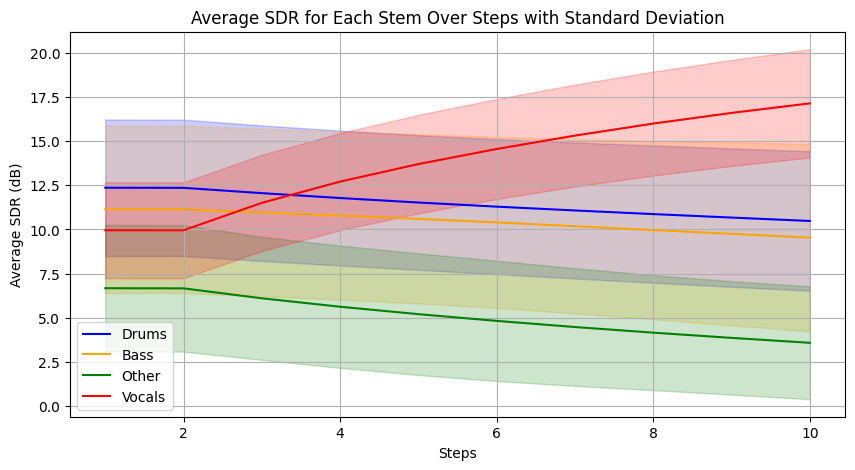

In [27]:
plot_sdr_results_with_std(sdr_mean, sdr_std)

## Remixing with previous-step-extracted-stem

In [28]:
# use the function to evaluate SDR across all the dataset using progressive inference
sdr_mean, sdr_std = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    normalize=True,
    overlap=0.0,
    target_stem="vocals",
    steps=10,
    mixture_update_mode="add sources",
    initial_gains={"bass": 0.25, "drums": 0.25, "vocals": 0.25, "other": 0.25},
    schedule_type="linear",
)


100%|██████████| 50/50 [06:33<00:00,  7.87s/it]


Average SDR results per stem: tensor([[ 12.3664,  11.1460,   6.6667,   9.9556],
        [ 12.2163,  11.0395,   6.5582,   9.8367],
        [ 11.8216,  10.5815,   5.9943,   9.7887],
        [ 10.3272,   6.8473,   3.6516,   9.6952],
        [  3.4644,  -5.1738,  -2.2556,   9.5907],
        [-30.7141, -25.7831, -12.2670,   9.5683],
        [-36.8530, -28.7874, -14.9733,   9.5515],
        [-38.4580, -31.2599, -16.8353,   9.5281],
        [-39.8117, -33.0020, -18.2084,   9.4995],
        [-39.8778, -34.7290, -19.2642,   9.4669]])
Standard deviation of SDR results per stem: tensor([[ 3.8711,  4.7480,  2.7201,  3.5867],
        [ 3.8223,  4.7253,  2.7359,  3.5759],
        [ 3.7824,  4.8067,  2.7797,  3.4613],
        [ 4.0210, 10.0446,  3.2505,  3.4179],
        [ 8.0865, 11.7806,  4.5572,  3.4584],
        [16.5867, 10.6303,  4.7294,  3.4360],
        [11.8347,  9.2667,  4.2744,  3.4299],
        [ 9.0716,  9.3598,  4.4393,  3.4248],
        [10.1612,  9.3538,  4.8099,  3.4181],
        [10

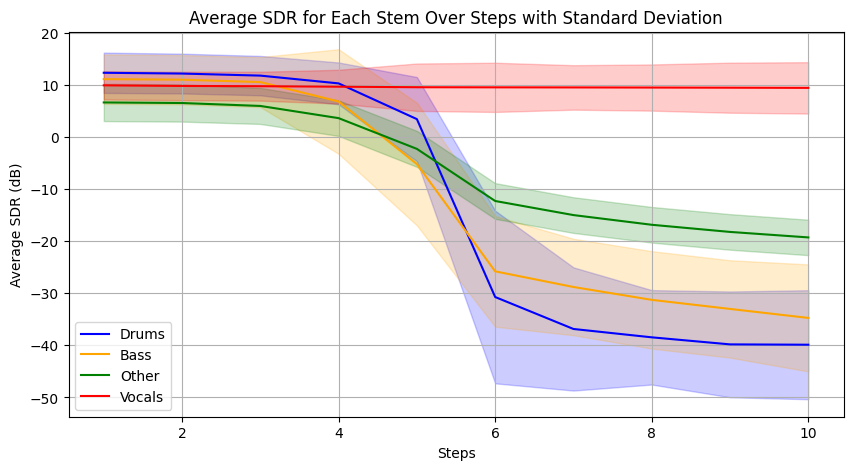

In [29]:
plot_sdr_results_with_std(sdr_mean, sdr_std)

## Remixing adding the resulting target stem to the original mixture

### Vocals

In [30]:
# use the function to evaluate SDR across all the dataset using progressive inference
sdr_mean_add_to_mix, sdr_std_add_to_mix = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    normalize=True,
    overlap=0.0,
    target_stem="vocals",
    steps = 10,
    mixture_update_mode="add to mixture",
)

100%|██████████| 50/50 [06:34<00:00,  7.89s/it]


Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3563, 11.1196,  6.6485,  9.9856],
        [12.3350, 11.0770,  6.6061,  9.9979],
        [12.2909, 11.0031,  6.5186,  9.9816],
        [12.2040, 10.8682,  6.3482,  9.9204],
        [12.0404, 10.5973,  6.0316,  9.8049],
        [11.7240, 10.0269,  5.4953,  9.6440],
        [11.0908,  8.3677,  4.5732,  9.4546],
        [ 9.8393,  4.7075,  2.9656,  9.2556],
        [ 6.0025, -3.2989, -0.6870,  9.0970]])
Standard deviation of SDR results per stem: tensor([[ 3.8711,  4.7480,  2.7201,  3.5867],
        [ 3.8727,  4.7591,  2.7221,  3.5405],
        [ 3.8750,  4.7773,  2.7265,  3.4993],
        [ 3.8787,  4.8102,  2.7371,  3.4604],
        [ 3.8874,  4.8704,  2.7595,  3.4316],
        [ 3.9093,  5.0383,  2.7972,  3.4157],
        [ 3.9647,  5.6042,  2.8755,  3.4018],
        [ 4.1003,  8.7817,  3.0930,  3.3887],
        [ 4.3110, 11.8453,  3.5113,  3.3944],
        [ 4.8013, 11.6986,  3.8059,  3.3846]])


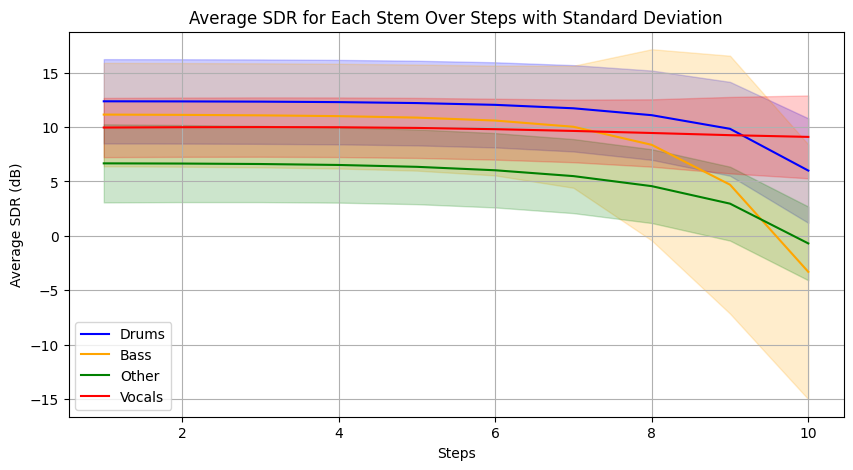

In [31]:
plot_sdr_results_with_std(sdr_mean_add_to_mix, sdr_std_add_to_mix)

### Drums

In [32]:
sdr_mean_add_to_mix, sdr_std_add_to_mix = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    normalize=True,
    overlap=0.0,
    target_stem="drums",
    steps = 10,
    mixture_update_mode="add to mixture",
)

100%|██████████| 50/50 [06:33<00:00,  7.88s/it]


Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3646, 11.0527,  6.6240,  9.9184],
        [12.3421, 10.9157,  6.5591,  9.8648],
        [12.2910, 10.7188,  6.4596,  9.7852],
        [12.1971, 10.4049,  6.3029,  9.6620],
        [12.0483,  9.8885,  6.0529,  9.4497],
        [11.8298,  8.5721,  5.5852,  8.9853],
        [11.5329,  6.1254,  4.6350,  8.0687],
        [11.1789,  1.5667,  3.1784,  6.1370],
        [10.7994, -7.8737, -0.2319,  1.0595]])
Standard deviation of SDR results per stem: tensor([[ 3.8711,  4.7480,  2.7201,  3.5867],
        [ 3.8533,  4.7830,  2.7304,  3.6304],
        [ 3.8345,  4.8336,  2.7475,  3.6836],
        [ 3.8139,  4.9086,  2.7766,  3.7479],
        [ 3.7947,  5.0678,  2.8255,  3.8234],
        [ 3.7801,  5.4464,  2.9163,  3.9480],
        [ 3.7696,  7.6295,  3.0199,  4.4630],
        [ 3.7427,  9.8054,  3.4012,  5.8589],
        [ 3.7236, 12.6255,  3.7114,  8.2782],
        [ 3.6932, 13.6670,  4.2825, 11.8339]])


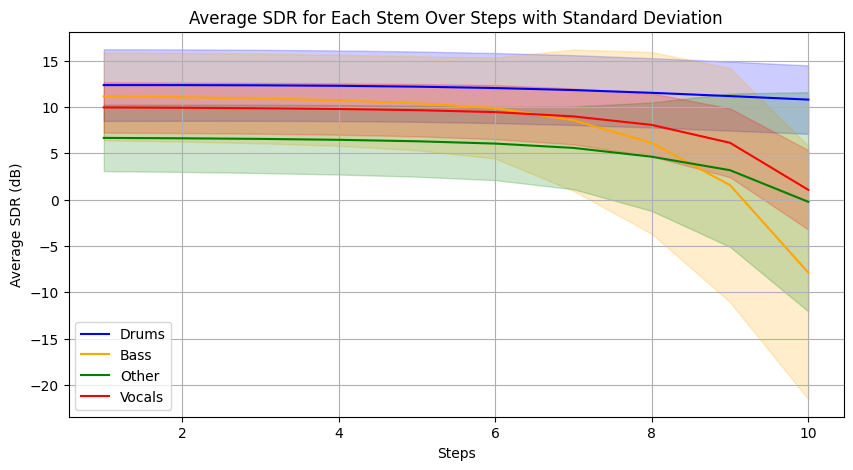

In [33]:
plot_sdr_results_with_std(sdr_mean_add_to_mix, sdr_std_add_to_mix)

### Bass

In [34]:
sdr_mean_add_to_mix, sdr_std_add_to_mix = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    normalize=True,
    overlap=0.0,
    target_stem="bass",
    steps = 10,
    mixture_update_mode="add to mixture",
)

100%|██████████| 50/50 [06:38<00:00,  7.97s/it]


Average SDR results per stem: tensor([[12.3664, 11.1460,  6.6667,  9.9556],
        [12.3562, 11.2597,  6.6631,  9.9388],
        [12.3250, 11.3509,  6.6345,  9.9111],
        [12.2521, 11.4014,  6.5610,  9.8630],
        [12.0848, 11.3903,  6.4031,  9.7708],
        [11.6577, 11.2844,  6.0785,  9.5823],
        [10.6473, 11.0855,  5.4001,  9.1696],
        [ 7.9706, 10.8023,  4.1036,  8.1766],
        [ 3.6194, 10.4682,  1.9188,  6.4950],
        [-5.2997, 10.2034, -2.2429,  0.1894]])
Standard deviation of SDR results per stem: tensor([[ 3.8711,  4.7480,  2.7201,  3.5867],
        [ 3.8777,  4.6798,  2.7481,  3.5891],
        [ 3.8864,  4.6307,  2.7839,  3.5892],
        [ 3.8976,  4.5976,  2.8345,  3.5852],
        [ 3.9224,  4.5653,  2.9108,  3.5824],
        [ 4.0406,  4.5266,  3.0196,  3.5847],
        [ 4.4206,  4.4806,  3.2038,  3.6300],
        [ 5.9813,  4.4354,  3.4034,  4.3964],
        [ 6.4564,  4.3819,  3.8160,  5.0493],
        [10.5991,  4.3434,  4.7732, 11.5661]])


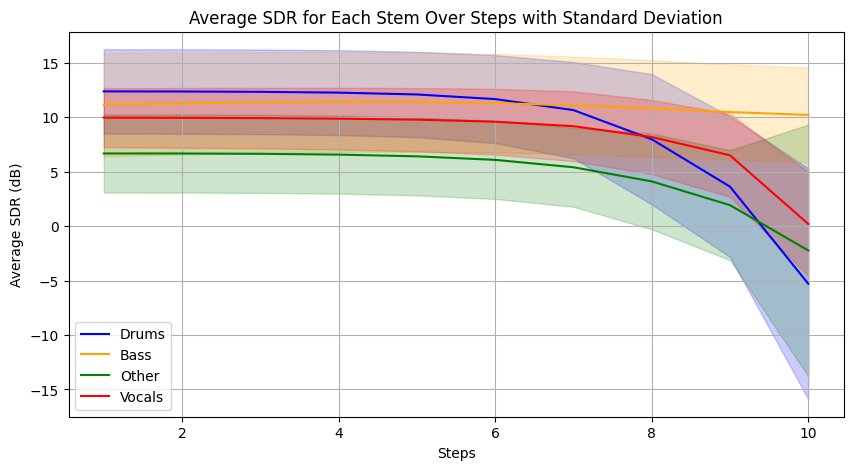

In [35]:
plot_sdr_results_with_std(sdr_mean_add_to_mix, sdr_std_add_to_mix)

### Other

In [37]:
sdr_mean_add_to_mix, sdr_std_add_to_mix = sdr_across_dataset(
    dataset_dict,
    model,
    sample_rate,
    device,
    normalize=True,
    overlap=0.0,
    target_stem="other",
    steps = 10,
    mixture_update_mode="add to mixture",
)

100%|██████████| 50/50 [06:43<00:00,  8.07s/it]


Average SDR results per stem: tensor([[ 12.3664,  11.1460,   6.6667,   9.9556],
        [ 12.3547,  11.0916,   6.6947,   9.9408],
        [ 12.3216,  10.9906,   6.7039,   9.8895],
        [ 12.2471,  10.7885,   6.6736,   9.7747],
        [ 12.0760,  10.4257,   6.5839,   9.5386],
        [ 11.6798,   9.6390,   6.4124,   9.0374],
        [ 10.9502,   7.8175,   6.1353,   7.9143],
        [  9.3082,   5.3443,   5.7916,   6.2651],
        [  7.0544,  -0.7777,   5.4136,   2.8312],
        [ -1.1113, -12.4330,   5.1289,  -4.3226]])
Standard deviation of SDR results per stem: tensor([[ 3.8711,  4.7480,  2.7201,  3.5867],
        [ 3.8812,  4.8040,  2.6875,  3.6114],
        [ 3.9002,  4.8897,  2.6483,  3.6662],
        [ 3.9354,  5.0444,  2.6049,  3.7649],
        [ 4.0146,  5.2413,  2.5737,  3.8940],
        [ 4.2115,  5.6767,  2.5588,  4.0627],
        [ 4.5210,  6.6304,  2.5574,  4.3485],
        [ 5.2192,  7.5862,  2.5610,  4.1105],
        [ 5.5550, 11.4084,  2.5474,  6.2533],
        [11

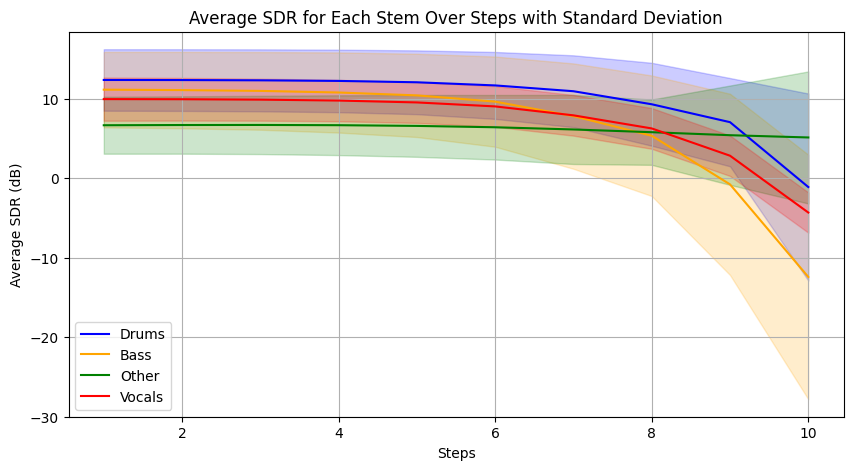

In [38]:
plot_sdr_results_with_std(sdr_mean_add_to_mix, sdr_std_add_to_mix)

## Data Driven Approach
##### Finds the optimal betas for the iterative shedule

<b> `save_stems_to_disk` </b>
This function saves separated audio stems to disk. It creates the specified directory (`save_dir`) if it does not exist, iterates through the `stems_dict` dictionary containing stem names and their corresponding waveforms, and saves each waveform as a `.wav` file using `torchaudio.save`.


<b> `load_stems_from_disk` </b>
This function loads separated audio stems from disk. It iterates through a predefined list of stem names (`drums`, `bass`, `other`, `vocals`) and attempts to load each stem's waveform from the specified `track_path`. If a file exists, it loads the waveform using `torchaudio.load` and moves it to the specified `device`. Missing files are logged as warnings.


<b> `optimal_beta_schedule` </b>
This function performs progressive inference to optimize the beta parameter for enhancing the separation of a target stem (`target_stem`). The procedure is as follows:
1. **Initialization**: Generate a range of beta values (`beta_values`) and create directories for saving output tracks if `save_to_disk` is enabled.
2. **Step 0**: Perform source separation on the original mixture (`new_mixture`) for all tracks in `dataset_dict`. Compute SDR values for each stem and save the separated stems to disk if required.
3. **Steps 1 to N**:
    - For each step, iterate through the beta values to find the optimal beta that maximizes the SDR for the target stem.
    - For each beta, create a new mixture by blending the original mixture and the target stem using the beta value. Perform source separation on the new mixture and compute SDR values for the target stem.
    - Track the best beta and corresponding separated sources for each track.
    - Save the separated stems to disk and compute average SDR values for all stems.
4. **Early Stopping**: Stop the process if the SDR for the target stem does not improve compared to the previous step.
5. **Return Results**: Return the optimal beta values and stepwise SDR values.


In [39]:
def save_stems_to_disk(stems_dict, save_dir, sample_rate):
    """Save separated tracks to disk."""
    os.makedirs(save_dir, exist_ok=True)
    for stem_name, waveform in stems_dict.items():
        file_path = os.path.join(save_dir, f"{stem_name}.wav")
        torchaudio.save(file_path, waveform.cpu(), sample_rate=sample_rate)

def load_stems_from_disk(track_path, device):
    """Load separated tracks from disk."""
    stems_dict = {}
    for stem_name in ["drums", "bass", "other", "vocals"]:
        file_path = os.path.join(track_path, f"{stem_name}.wav")
        if os.path.isfile(file_path):
            waveform, _ = torchaudio.load(file_path)
            stems_dict[stem_name] = waveform.to(device)
        else:
            print(f"Warning: file not found {file_path}")
    return stems_dict

def optimal_beta_schedule(
        model,
        dataset_dict,
        sample_rate,
        overlap,
        device,
        steps,
        target_stem="vocals",
        precision=None,
        normalize=True,
        wiener_filter=False,
        save_to_disk=True):

    beta_values = np.linspace(0, 1, precision)[1:]
    save_dir = "output_tracks"
    if save_to_disk:
        os.makedirs(save_dir, exist_ok=True)

    optimal_betas = np.zeros(steps)
    stepwise_sdrs = [torch.zeros(4) for _ in range(steps + 1)]

    # Step 0
    print("Step 0")
    sdr_collection = []
    for track_name, stems_dict in tqdm(dataset_dict.items()):
        if "new_mixture" not in stems_dict:
            print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)
        separated_sources = separate_sources(model, mixture, sample_rate, overlap, device, normalize)
        sdr_results = compute_sdrs(model, stems_dict, separated_sources, device)

        stems_dict_out = {stem_name: separated_sources[0, i].cpu() for i, stem_name in enumerate(model.sources)}
        if save_to_disk:
            track_save_path = os.path.join(save_dir, "step_0", track_name)
            save_stems_to_disk(stems_dict_out, track_save_path, sample_rate)

        sdr_step0_tensor = torch.tensor([sdr_results[stem][0] for stem in model.sources])
        sdr_collection.append(sdr_step0_tensor)

    stepwise_sdrs[0] = torch.mean(torch.stack(sdr_collection), dim=0)
    print(f"Step 0 SDR mean value for {target_stem}: {stepwise_sdrs[0]}")

    # Steps 1 to N
    for number_of_step in range(1, steps + 1):
        print(f"------------Step {number_of_step}------------")
        best_sdr_value = -np.inf
        best_beta = None
        best_estimates_all = {}
        target_index = model.sources.index(target_stem)

        for beta in beta_values:
            sdr_values_list = []
            current_estimates_all = {}

            for track_name, stems_dict in tqdm(dataset_dict.items()):
                if "new_mixture" not in stems_dict:
                    print(f"Skipping track {track_name} as it does not contain a new mixture.")
                    continue

                if save_to_disk:
                    track_path = os.path.join(save_dir, f"step_{number_of_step - 1}", track_name)
                    prev_stems_dict = load_stems_from_disk(track_path, device)
                    target_track = prev_stems_dict[target_stem].to(device)
                else:
                    target_track = stems_dict[target_stem].to(device)

                mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)
                new_mix = mixture * (1 - beta) + target_track * beta
                new_mix = new_mix / new_mix.abs().max()

                separated_sources = separate_sources(model, new_mix, sample_rate, overlap, device, normalize)
                if wiener_filter:
                    separated_sources[:, target_index] = wiener_filtering(separated_sources, new_mix, target_index)

                predicted_stem = separated_sources[0, target_index].to(device)
                original_stem = stems_dict[target_stem].to(device)
                sdr_value_target_stem = evaluate_sdr(original_stem, predicted_stem, device=device)
                sdr_values_list.append(sdr_value_target_stem)

                current_estimates_all[track_name] = separated_sources

            mean_sdr = torch.mean(torch.tensor(sdr_values_list))

            if mean_sdr > best_sdr_value:
                best_sdr_value = mean_sdr
                best_beta = beta
                best_estimates_all = current_estimates_all

        print(f"New best SDR value found at {number_of_step} with beta = {best_beta} is {best_sdr_value}")
        optimal_betas[number_of_step - 1] = best_beta

        # Final calculation of averages using best_estimates_all
        sdr_collection = []
        for track_name, stems_dict in dataset_dict.items():
            if "new_mixture" not in stems_dict or track_name not in best_estimates_all:
                continue

            separated_sources = best_estimates_all[track_name]
            sdr_results = compute_sdrs(model, stems_dict, separated_sources, device)

            if save_to_disk:
                stems_dict_out = {stem_name: separated_sources[0, i].cpu() for i, stem_name in enumerate(model.sources)}
                track_save_path = os.path.join(save_dir, f"step_{number_of_step}", track_name)
                save_stems_to_disk(stems_dict_out, track_save_path, sample_rate)

            sdr_collection.append(torch.tensor([sdr_results[stem][0] for stem in model.sources]))

        if len(sdr_collection) > 0:
            stepwise_sdrs[number_of_step] = torch.mean(torch.stack(sdr_collection), dim=0)
            print(f"Step {number_of_step} SDR mean values: {stepwise_sdrs[number_of_step]}")

        # Early stopping
        if stepwise_sdrs[number_of_step][target_index] <= stepwise_sdrs[number_of_step - 1][target_index]:
            print(f"Stopping early at step {number_of_step} as SDR did not improve.")
            return optimal_betas, stepwise_sdrs

    return optimal_betas, stepwise_sdrs

In [40]:
steps = 10 # number of iterations
precision = 11 # precision of the beta values: in how many beta values we want to divide the range

optimal_betas, stepwise_sdrs = optimal_beta_schedule(
        model = model,
        dataset_dict = dataset_dict,
        target_stem = "vocals",
        sample_rate = sample_rate,
        overlap = 0.0,
        device = device,
        steps = steps,
        precision=precision
        )

Step 0


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Step 0 SDR mean value for vocals: tensor([12.3664, 11.1460,  6.6667,  9.9556])
------------Step 1------------


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


New best SDR value found at 1 with beta = 0.8 is 10.025650978088379
Step 1 SDR mean values: tensor([11.0499,  7.7920,  4.3892, 10.0257])
------------Step 2------------


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


New best SDR value found at 2 with beta = 0.1 is 10.021869659423828
Step 2 SDR mean values: tensor([12.3376, 11.0931,  6.6226, 10.0219])
Stopping early at step 2 as SDR did not improve.


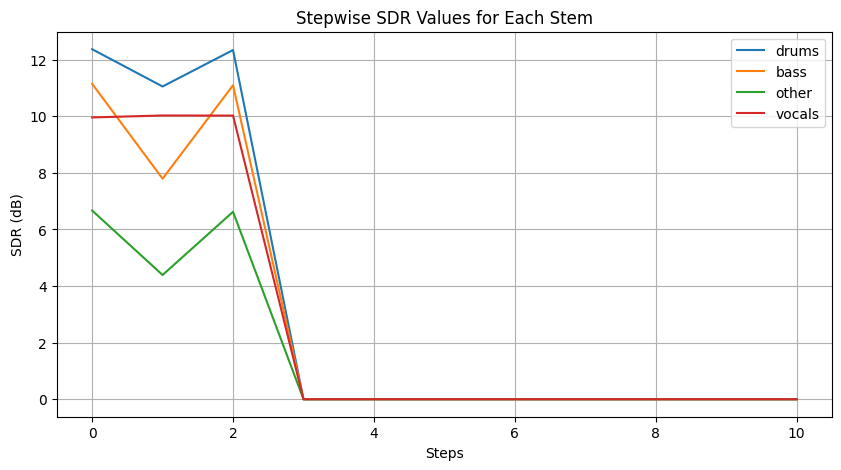

In [41]:
def plot_stepwise_sdrs(stepwise_sdrs, stems):
    """
    Plot the SDR values for each stem across steps.

    Args:
        stepwise_sdrs (list): List of tensors containing SDR values for each step.
        stems (list): List of stem names.
    """
    steps = np.arange(len(stepwise_sdrs))
    sdr_values = torch.stack(stepwise_sdrs).cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i, stem in enumerate(stems):
        plt.plot(steps, sdr_values[:, i], label=stem)

    plt.xlabel('Steps')
    plt.ylabel('SDR (dB)')
    plt.title('Stepwise SDR Values for Each Stem')
    plt.legend()
    plt.grid()
    plt.show()

# Define the stems based on the model sources
stems = model.sources

# Plot the stepwise SDR values
plot_stepwise_sdrs(stepwise_sdrs, stems)